<a href="https://colab.research.google.com/github/kridtapon/KST-Echo-Divergence/blob/main/KST_Echo_Divergence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.6/527.6 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.7/295.7 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.2 MB/s eta 0:00:00


In [2]:
pip install --upgrade yfinance

In [32]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt

# ------------------- Indicator Calculations -------------------

def calculate_kst(close, r1=10, r2=15, r3=20, r4=30, n1=10, n2=10, n3=10, n4=15, sig=9):
    roc1 = close.pct_change(r1) * 100
    roc2 = close.pct_change(r2) * 100
    roc3 = close.pct_change(r3) * 100
    roc4 = close.pct_change(r4) * 100

    sma1 = roc1.rolling(n1).mean()
    sma2 = roc2.rolling(n2).mean()
    sma3 = roc3.rolling(n3).mean()
    sma4 = roc4.rolling(n4).mean()

    kst = sma1 + (sma2 * 2) + (sma3 * 3) + (sma4 * 4)
    signal = kst.rolling(sig).mean()

    return kst, signal

def calculate_dpo(close, period=20):
    """Detrended Price Oscillator"""
    shifted_ma = close.rolling(window=period).mean().shift(int(period / 2) + 1)
    dpo = close - shifted_ma
    return dpo

# ------------------- Data Fetching -------------------

symbol = 'GE'
start_date = '2019-01-01'
end_date = '2025-01-01'

df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

# ------------------- Indicators -------------------

df['KST'], df['KST_Signal'] = calculate_kst(df['Close'])
df['DPO'] = calculate_dpo(df['Close'])
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# ------------------- Divergence Approximation -------------------

# Simulate bullish divergence:
# - Price makes lower low
# - DPO makes higher low

df['Price_LL'] = (df['Close'] < df['Close'].shift(10))
df['DPO_HL'] = (df['DPO'] > df['DPO'].shift(10))

# Simulate bearish divergence:
df['Price_HH'] = (df['Close'] > df['Close'].shift(10))
df['DPO_LH'] = (df['DPO'] < df['DPO'].shift(10))

# ------------------- Entry/Exit Conditions -------------------

df['KST_Cross'] = (df['KST'] > df['KST_Signal'])
df['Entry'] = ((df['KST'] > 0) | df['KST_Cross']) & df['Price_LL'] & df['DPO_HL']
df['Exit'] = ((df['KST'] < 0) | (~df['KST_Cross'])) & df['Price_HH'] & df['DPO_LH']

# ------------------- Backtesting -------------------

portfolio = vbt.Portfolio.from_signals(
    close=df['Close'],
    entries=df['Entry'],
    exits=df['Exit'],
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='D'
)

print(portfolio.stats())
portfolio.plot().show()


[*********************100%***********************]  1 of 1 completed


Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                         1258 days 00:00:00
Start Value                              100000.0
End Value                           137006.827137
Total Return [%]                        37.006827
Benchmark Return [%]                    186.77216
Max Gross Exposure [%]                      100.0
Total Fees Paid                       2026.646845
Max Drawdown [%]                        58.241256
Max Drawdown Duration           681 days 00:00:00
Total Trades                                   10
Total Closed Trades                            10
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                                 60.0
Best Trade [%]                          71.112512
Worst Trade [%]                        -44.664968
Avg Winning Trade [%]                   20.618827
Avg Losing Trade [%]                   -13.524194


In [33]:
# ------------------- Entry/Exit Conditions -------------------

df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]
df['Entry'] = (df['KST'] > 0) & (df['DPO'] > 0)
df['Exit'] = (df['KST'] < 0) & (df['DPO'] < 0)

# ------------------- Backtesting -------------------

portfolio = vbt.Portfolio.from_signals(
    close=df['Close'],
    entries=df['Entry'],
    exits=df['Exit'],
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='D'
)

print(portfolio.stats())
portfolio.plot().show()

Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                         1258 days 00:00:00
Start Value                              100000.0
End Value                           343075.003406
Total Return [%]                       243.075003
Benchmark Return [%]                    186.77216
Max Gross Exposure [%]                      100.0
Total Fees Paid                       4877.743967
Max Drawdown [%]                         34.45469
Max Drawdown Duration           521 days 00:00:00
Total Trades                                   14
Total Closed Trades                            14
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                            28.571429
Best Trade [%]                          94.708725
Worst Trade [%]                         -7.219338
Avg Winning Trade [%]                   59.370209
Avg Losing Trade [%]                    -5.335035


In [31]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt

# ------------------- Indicator Calculations -------------------

def calculate_kst(close, r1=10, r2=15, r3=20, r4=30, n1=10, n2=10, n3=10, n4=15, sig=9):
    roc1 = close.pct_change(r1) * 100
    roc2 = close.pct_change(r2) * 100
    roc3 = close.pct_change(r3) * 100
    roc4 = close.pct_change(r4) * 100

    sma1 = roc1.rolling(n1).mean()
    sma2 = roc2.rolling(n2).mean()
    sma3 = roc3.rolling(n3).mean()
    sma4 = roc4.rolling(n4).mean()

    kst = sma1 + (sma2 * 2) + (sma3 * 3) + (sma4 * 4)
    signal = kst.rolling(sig).mean()

    return kst, signal

def calculate_dpo(close, period=20):
    """Detrended Price Oscillator"""
    shifted_ma = close.rolling(window=period).mean().shift(int(period / 2) + 1)
    dpo = close - shifted_ma
    return dpo

# ------------------- Data Fetching -------------------

symbol = 'GE'
start_date = '2019-01-01'
end_date = '2025-01-01'

df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

# ------------------- Indicators -------------------

df['KST'], df['KST_Signal'] = calculate_kst(df['Close'])
df['DPO'] = calculate_dpo(df['Close'])

# ------------------- Divergence Approximation -------------------

# Simulate bullish divergence:
# - Price makes lower low
# - DPO makes higher low

df['Price_LL'] = (df['Close'] < df['Close'].shift(10))
df['DPO_HL'] = (df['DPO'] > df['DPO'].shift(10))

# Simulate bearish divergence:
df['Price_HH'] = (df['Close'] > df['Close'].shift(10))
df['DPO_LH'] = (df['DPO'] < df['DPO'].shift(10))

# ------------------- Entry/Exit Conditions -------------------

df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]
df['Entry'] = (df['KST'] > 0) & (df['DPO'] > 0)
df['Exit'] = (df['KST'] < 0) & (df['DPO'] < 0)

# ------------------- Backtesting -------------------

portfolio = vbt.Portfolio.from_signals(
    close=df['Close'],
    entries=df['Entry'],
    exits=df['Exit'],
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='D'
)

print(portfolio.stats())
portfolio.plot().show()


[*********************100%***********************]  1 of 1 completed


Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                         1258 days 00:00:00
Start Value                              100000.0
End Value                           343075.003406
Total Return [%]                       243.075003
Benchmark Return [%]                    186.77216
Max Gross Exposure [%]                      100.0
Total Fees Paid                       4877.743967
Max Drawdown [%]                         34.45469
Max Drawdown Duration           521 days 00:00:00
Total Trades                                   14
Total Closed Trades                            14
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                            28.571429
Best Trade [%]                          94.708725
Worst Trade [%]                         -7.219338
Avg Winning Trade [%]                   59.370209
Avg Losing Trade [%]                    -5.335035


[*********************100%***********************]  1 of 1 completed


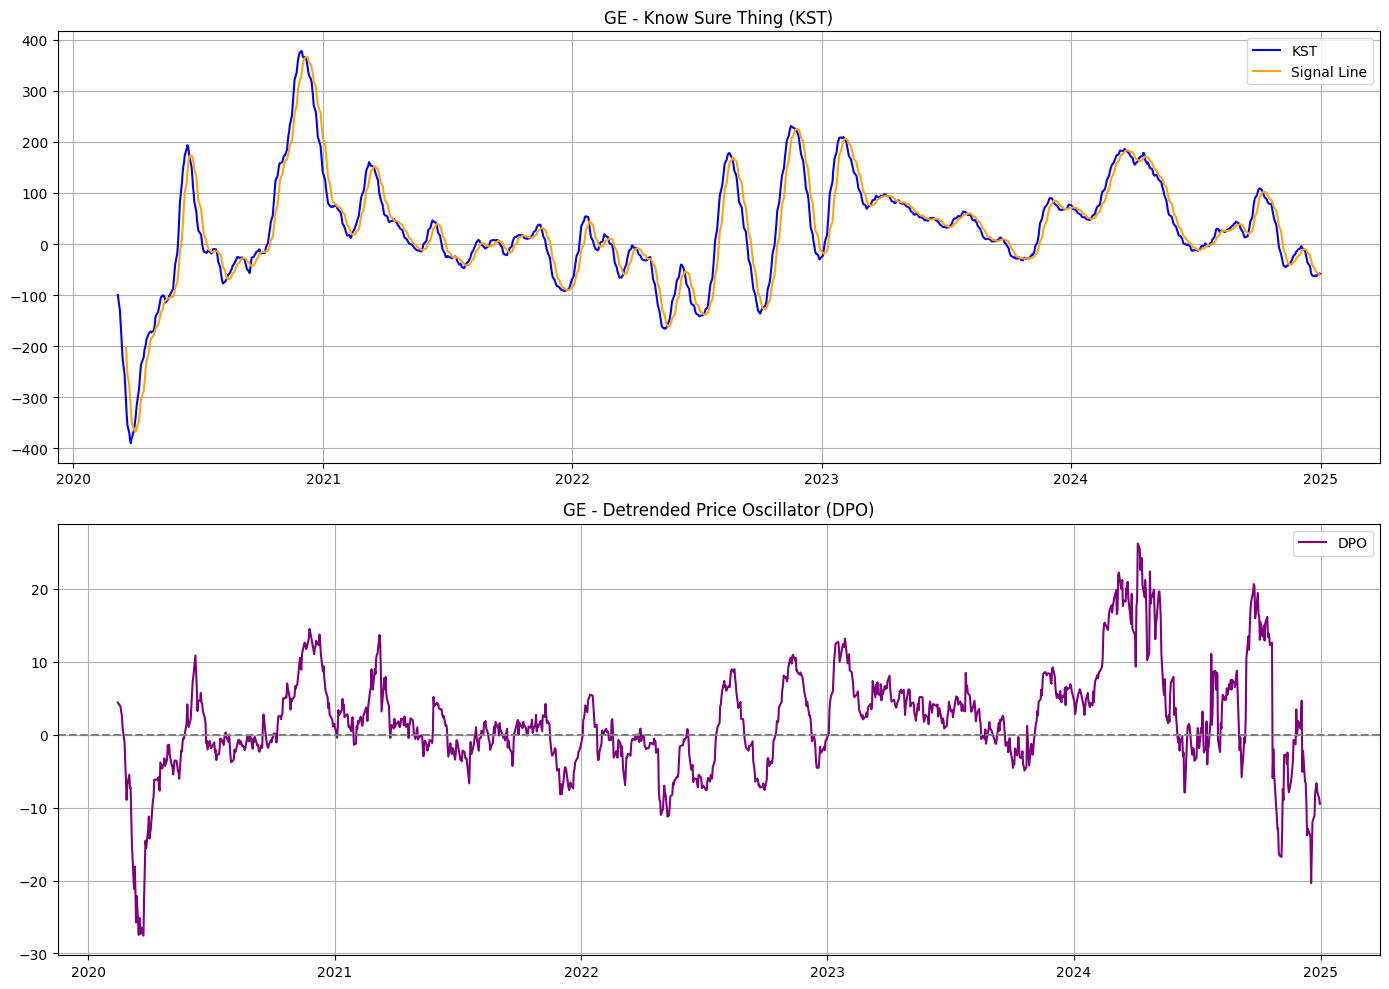

In [34]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# --------- Indicator Calculations ---------

def calculate_kst(close, r1=10, r2=15, r3=20, r4=30, n1=10, n2=10, n3=10, n4=15, sig=9):
    roc1 = close.pct_change(r1) * 100
    roc2 = close.pct_change(r2) * 100
    roc3 = close.pct_change(r3) * 100
    roc4 = close.pct_change(r4) * 100

    sma1 = roc1.rolling(n1).mean()
    sma2 = roc2.rolling(n2).mean()
    sma3 = roc3.rolling(n3).mean()
    sma4 = roc4.rolling(n4).mean()

    kst = sma1 + (sma2 * 2) + (sma3 * 3) + (sma4 * 4)
    signal = kst.rolling(sig).mean()

    return kst, signal

def calculate_dpo(close, period=20):
    shifted_ma = close.rolling(window=period).mean().shift(int(period / 2) + 1)
    dpo = close - shifted_ma
    return dpo

# --------- Data Fetching ---------

symbol = 'GE'
start_date = '2020-01-01'
end_date = '2025-01-01'

df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

# --------- Indicator Calculation ---------

df['KST'], df['KST_Signal'] = calculate_kst(df['Close'])
df['DPO'] = calculate_dpo(df['Close'])

# --------- Plotting ---------

plt.figure(figsize=(14, 10))

# --- KST Plot ---
plt.subplot(2, 1, 1)
plt.plot(df.index, df['KST'], label='KST', color='blue')
plt.plot(df.index, df['KST_Signal'], label='Signal Line', color='orange')
plt.title(f"{symbol} - Know Sure Thing (KST)")
plt.legend()
plt.grid(True)

# --- DPO Plot ---
plt.subplot(2, 1, 2)
plt.plot(df.index, df['DPO'], label='DPO', color='purple')
plt.axhline(0, color='gray', linestyle='--')
plt.title(f"{symbol} - Detrended Price Oscillator (DPO)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


[*********************100%***********************]  1 of 1 completed


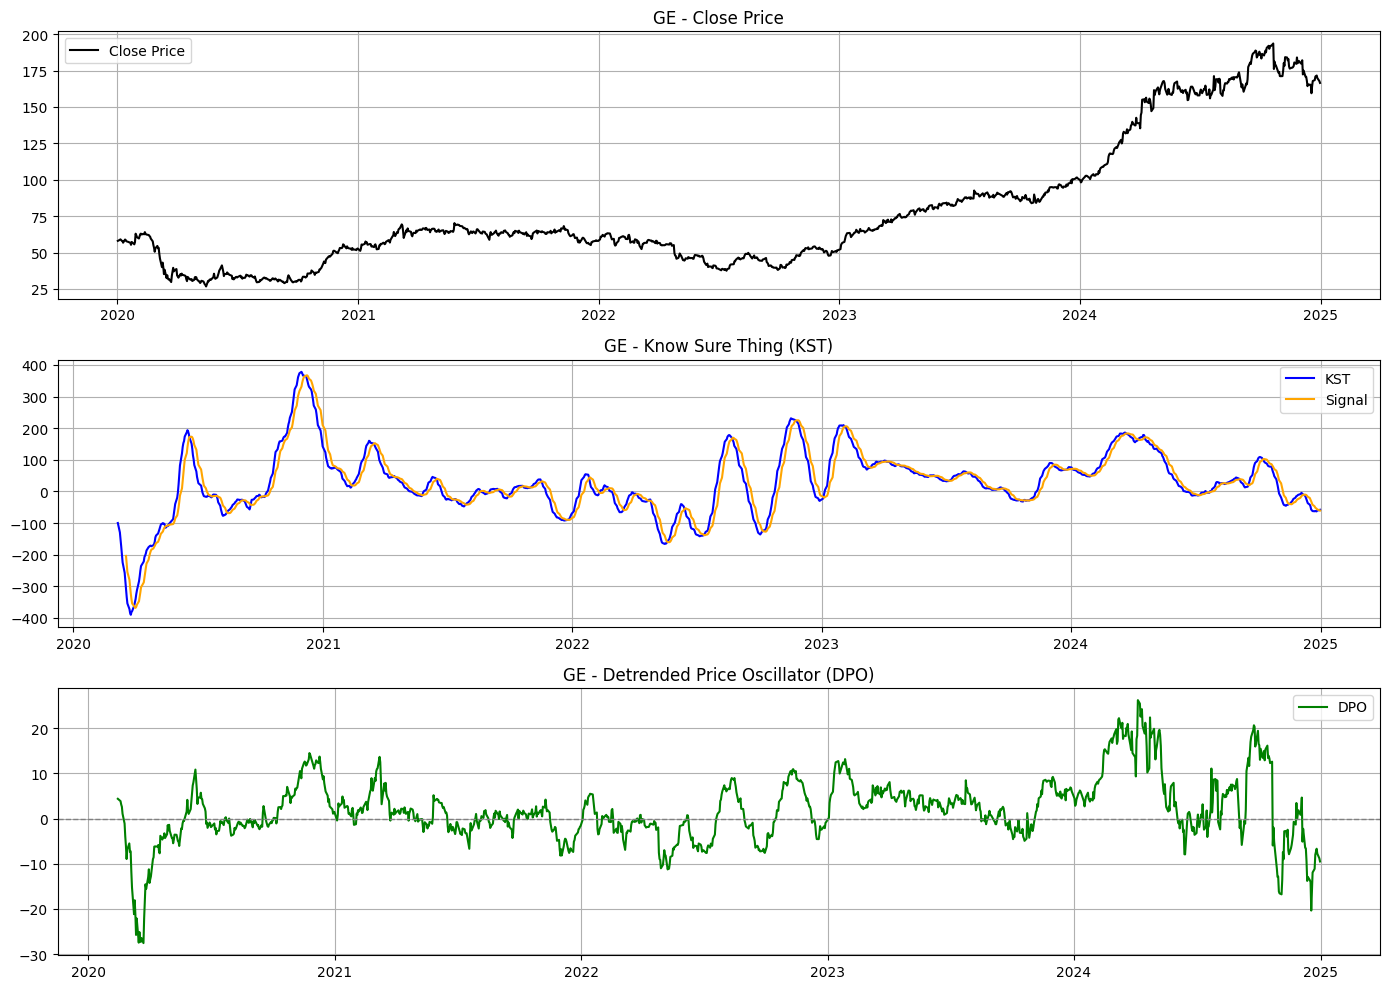

In [37]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# ------------------- Indicator Calculations -------------------

def calculate_kst(close, r1=10, r2=15, r3=20, r4=30, n1=10, n2=10, n3=10, n4=15, sig=9):
    roc1 = close.pct_change(r1) * 100
    roc2 = close.pct_change(r2) * 100
    roc3 = close.pct_change(r3) * 100
    roc4 = close.pct_change(r4) * 100

    sma1 = roc1.rolling(n1).mean()
    sma2 = roc2.rolling(n2).mean()
    sma3 = roc3.rolling(n3).mean()
    sma4 = roc4.rolling(n4).mean()

    kst = sma1 + (sma2 * 2) + (sma3 * 3) + (sma4 * 4)
    signal = kst.rolling(sig).mean()

    return kst, signal

def calculate_dpo(close, period=20):
    shifted_ma = close.rolling(window=period).mean().shift(int(period / 2) + 1)
    dpo = close - shifted_ma
    return dpo

# ------------------- Data Fetching -------------------

symbol = 'GE'
start_date = '2020-01-01'
end_date = '2025-01-01'

df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

# ------------------- Indicator Application -------------------

df['KST'], df['KST_Signal'] = calculate_kst(df['Close'])
df['DPO'] = calculate_dpo(df['Close'])

# ------------------- Plotting -------------------

plt.figure(figsize=(14, 10))

# Plot 1: Close Price
plt.subplot(3, 1, 1)
plt.plot(df.index, df['Close'], label='Close Price', color='black')
plt.title(f"{symbol} - Close Price")
plt.legend()
plt.grid(True)

# Plot 2: KST Indicator
plt.subplot(3, 1, 2)
plt.plot(df.index, df['KST'], label='KST', color='blue')
plt.plot(df.index, df['KST_Signal'], label='Signal', color='orange')
plt.title(f"{symbol} - Know Sure Thing (KST)")
plt.legend()
plt.grid(True)

# Plot 3: DPO
plt.subplot(3, 1, 3)
plt.plot(df.index, df['DPO'], label='DPO', color='green')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title(f"{symbol} - Detrended Price Oscillator (DPO)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


[*********************100%***********************]  1 of 1 completed


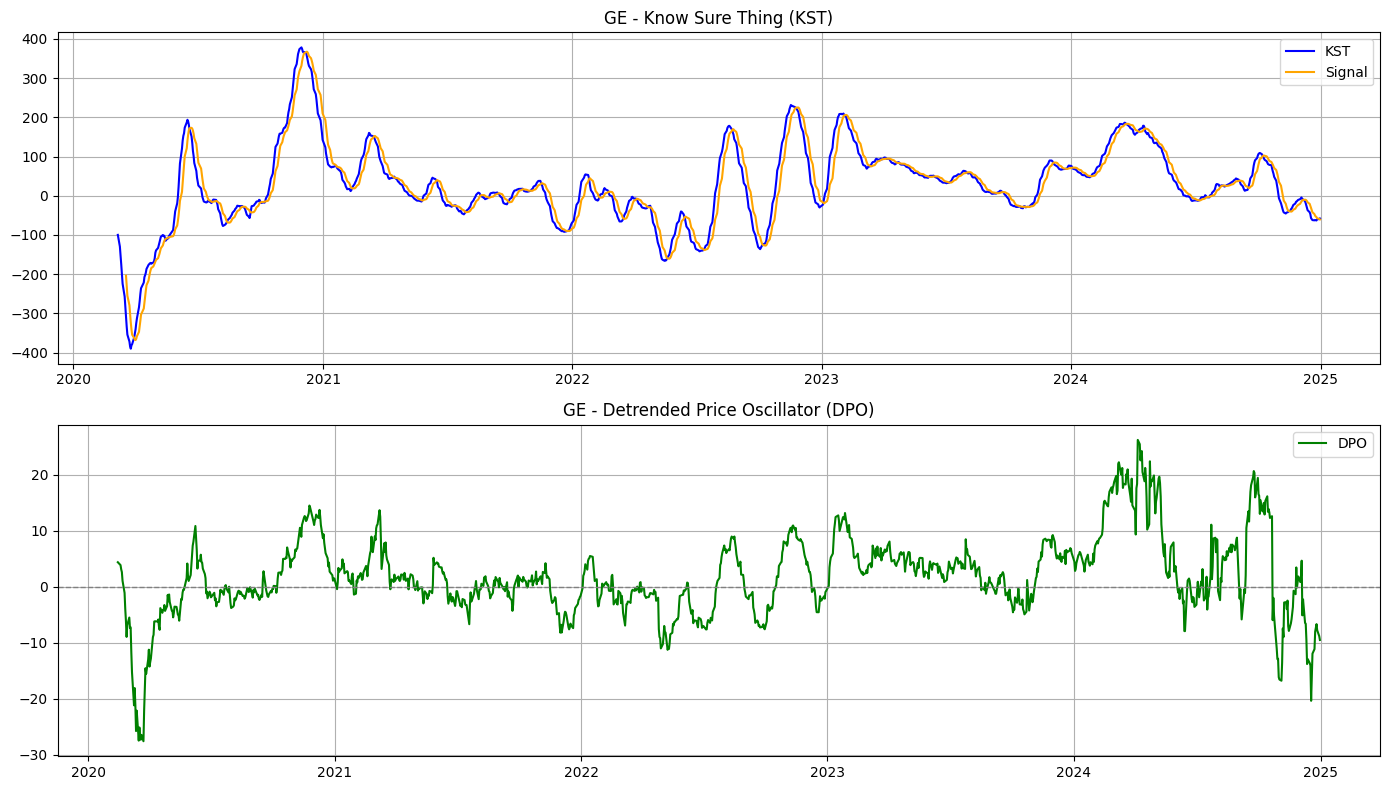

In [38]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# ------------------- Indicator Calculations -------------------

def calculate_kst(close, r1=10, r2=15, r3=20, r4=30, n1=10, n2=10, n3=10, n4=15, sig=9):
    roc1 = close.pct_change(r1) * 100
    roc2 = close.pct_change(r2) * 100
    roc3 = close.pct_change(r3) * 100
    roc4 = close.pct_change(r4) * 100

    sma1 = roc1.rolling(n1).mean()
    sma2 = roc2.rolling(n2).mean()
    sma3 = roc3.rolling(n3).mean()
    sma4 = roc4.rolling(n4).mean()

    kst = sma1 + (sma2 * 2) + (sma3 * 3) + (sma4 * 4)
    signal = kst.rolling(sig).mean()

    return kst, signal

def calculate_dpo(close, period=20):
    shifted_ma = close.rolling(window=period).mean().shift(int(period / 2) + 1)
    dpo = close - shifted_ma
    return dpo

# ------------------- Data Fetching -------------------

symbol = 'GE'
start_date = '2020-01-01'
end_date = '2025-01-01'

df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

# ------------------- Indicator Application -------------------

df['KST'], df['KST_Signal'] = calculate_kst(df['Close'])
df['DPO'] = calculate_dpo(df['Close'])

# ------------------- Plotting -------------------

plt.figure(figsize=(14, 8))

# KST Indicator Plot
plt.subplot(2, 1, 1)
plt.plot(df.index, df['KST'], label='KST', color='blue')
plt.plot(df.index, df['KST_Signal'], label='Signal', color='orange')
plt.title(f"{symbol} - Know Sure Thing (KST)")
plt.legend()
plt.grid(True)

# DPO Plot
plt.subplot(2, 1, 2)
plt.plot(df.index, df['DPO'], label='DPO', color='green')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title(f"{symbol} - Detrended Price Oscillator (DPO)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
